Take a copy of this notebook for each model you will implement.

This is the initial notebook — any changes will be made here before starting model building to ensure consistency across all notebooks.

**Key Consistency Tips**

* Standardized Headings: Use identical section names across all notebooks.

* Code Comments: Explain non-trivial steps (e.g., "Handling class imbalance with SMOTE").

* Version Control: Add a requirements.txt in the repo for dependency management. مش لازم

* Outputs: Save all plots/figures to a /results folder with consistent naming (e.g., XGBoost_SHAP.png).
اعتقد هتبقى كويسة عشان واحنا بنعمل البيبر ما نقعدش ناخد سكرينات


* Reproducibility: Set global random seeds (e.g., np.random.seed(42)).

# **Imports**

In [1]:
%%capture
!pip install -q lime shap

In [8]:
# Import model-specific libraries (e.g., sklearn, XGBoost, SHAP)
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import kagglehub
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, learning_curve, ValidationCurveDisplay
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc
from sklearn.inspection import PartialDependenceDisplay,permutation_importance
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import lime
import lime.lime_tabular
import shap
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, RocCurveDisplay, auc, roc_curve
import warnings
warnings.filterwarnings('ignore')

# **Utils**

In [3]:
def our_confusion_matrix(model, name='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, cmap="Oranges", ax=ax1)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Oranges", ax=ax2)
    plt.title(f"{name} Confusion Matrix")

def our_roc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    roc1 = RocCurveDisplay.from_estimator(
    model, X_train, y_train,
    name=name, ax=ax1,
    color="orange"
    )
    roc2 = RocCurveDisplay.from_estimator(
        model, X_test, y_test,
        name=name, ax=ax2,
        color="orange"
    )
    ax1.fill_between(roc1.fpr, roc1.tpr, alpha=0.4, color="orange")
    ax2.fill_between(roc2.fpr, roc2.tpr, alpha=0.4, color="orange")
    ax1.set_title(f"{name} Training ROC Curve", fontsize=16)
    ax2.set_title(f"{name} Testing ROC Curve", fontsize=16)
    for ax in [ax1, ax2]:
        ax.grid(alpha=0.5)

def our_learning_curve(model, name='Model'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 10), random_state=0
    )

    plt.figure(figsize=(13, 8))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', color="mediumseagreen", label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', color="royalblue", label="Cross-validation score")
    plt.title(f"{name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid(alpha=0.5)

def our_prc(model, name="Model"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 13))
    train_disp = PrecisionRecallDisplay.from_estimator(model, X_train, y_train, ax=ax1, color='orange')
    test_disp = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax2, color='orange')
    ax1.set_title(f"{name} Precision-Recall Curve - Train")
    ax2.set_title(f"{name} Precision-Recall Curve - Test")
    ax1.fill_between(train_disp.recall, train_disp.precision, alpha=0.4, color='orange')
    ax2.fill_between(test_disp.recall, test_disp.precision, alpha=0.4, color='orange')

# **Load Processed Dat**a

In [4]:
path = kagglehub.dataset_download('mohamedhassan77/xai-project-processed-data')
df = pd.read_csv(f"{path}/combined_adasyn_train_test.csv")
df

100%|██████████| 145k/145k [00:00<00:00, 58.8MB/s]

Extracting files...


,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,promotion_velocity,workload_score,compensation_ratio,Attrition,Set
0,31,2,1062,1,24,3,3,3,0,96,...,3,10.0,9,1,8,9.999900,1,1.019760,0,Train
1,50,2,328,1,1,3,3,3,1,86,...,2,3.0,2,0,2,300000.000000,2,1.281918,0,Train
2,46,2,717,1,13,4,1,3,1,34,...,3,10.0,7,0,9,1000000.000000,1,0.832635,0,Train
3,44,2,170,1,1,4,1,2,1,78,...,3,2.0,0,2,2,0.999995,1,0.753443,0,Train
4,26,1,1479,1,1,3,1,3,0,84,...,1,6.0,5,1,4,5.999940,3,1.007878,0,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2042,56,2,1162,1,24,2,1,1,1,97,...,3,4.0,2,1,0,3.999960,1,0.898732,1,Test
2043,46,2,669,2,9,2,3,3,1,64,...,3,9.0,8,4,7,2.249994,1,1.558490,1,Test
2044,30,2,1240,0,9,3,0,3,1,48,...,1,11.0,9,4,7,2.749993,7,2.052053,0,Test
2045,31,2,741,1,2,4,1,2,1,69,...,4,5.0,2,0,3,500000.000000,0,1.207921,0,Test


In [5]:
train_df = df[df['Set'] == 'Train'].drop(columns=['Set'])
test_df = df[df['Set'] == 'Test'].drop(columns=['Set'])

X_train = train_df.drop(columns=['Attrition'])
y_train = train_df['Attrition']

X_test = test_df.drop(columns=['Attrition'])
y_test = test_df['Attrition']

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (1589, 33) y_train: (1589,)
X_test: (458, 33) y_test: (458,)


# **Model-Specific EDA (Optional)**

Target variable distribution in the training set:
Attrition
1    804
0    785
Name: count, dtype: int64


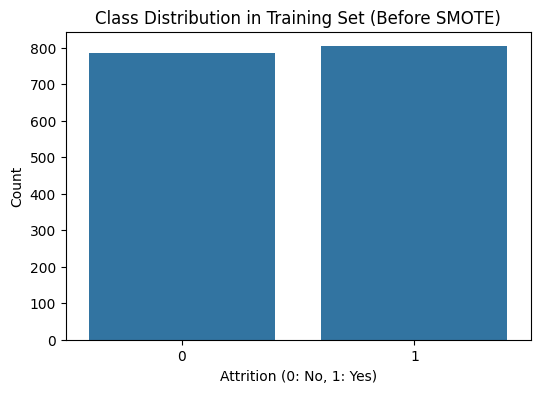

In [6]:
print("Target variable distribution in the training set:")
print(y_train.value_counts())
plt.figure(figsize=(6, 4))
sns.countplot(x=y_train)
plt.title('Class Distribution in Training Set (Before SMOTE)')
plt.xlabel('Attrition (0: No, 1: Yes)')
plt.ylabel('Count')
plt.show()

# **Model Initialization**

In [9]:
nb_classifier = GaussianNB()
smote = SMOTE(random_state=123)
pipeline = ImbPipeline([
    ('smote', smote),
    ('classifier', nb_classifier)
])

# **Model Training**

In [10]:
pipeline.fit(X_train, y_train)
print("Training complete.")

Training complete.


# **Model Evaluation**

In [11]:
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

In [12]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4279


In [13]:
print("Classification Report:")
report = classification_report(y_test, y_pred, target_names=['No Attrition', 'Attrition'])
print(report)

Classification Report:
              precision    recall  f1-score   support

No Attrition       0.85      0.36      0.51       373
   Attrition       0.20      0.72      0.32        85

    accuracy                           0.43       458
   macro avg       0.53      0.54      0.41       458
weighted avg       0.73      0.43      0.47       458



Confusion Matrix:


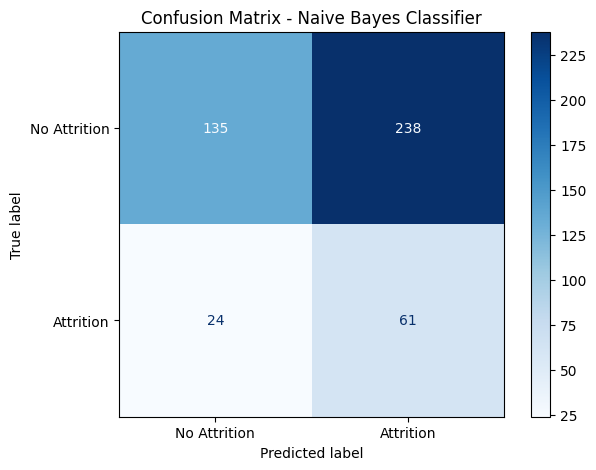

In [15]:
print("Confusion Matrix:")
fig, ax = plt.subplots(figsize=(7, 5))
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test,
                                      display_labels=['No Attrition', 'Attrition'],
                                      cmap='Blues', ax=ax)
plt.title('Confusion Matrix - Naive Bayes Classifier')
plt.show()

The mosel struggles to identify who will stay, most of the time the model over predict-predicting attrition and making its positive prediction unreliable.

ROC Curve and AUC:


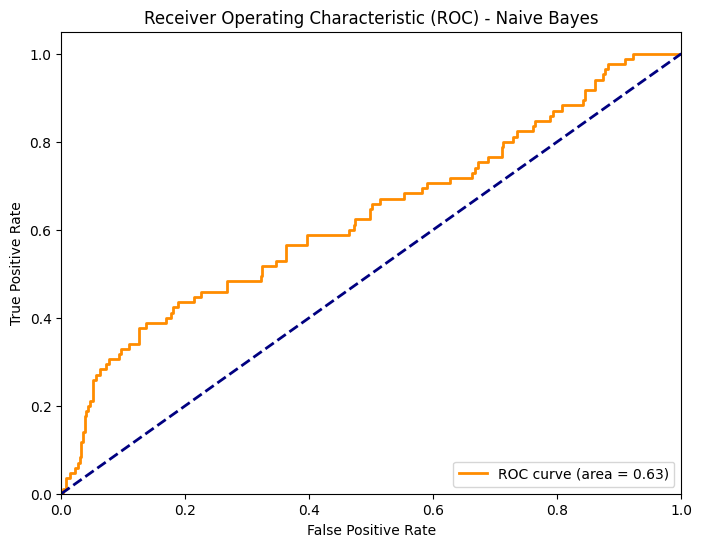

AUC: 0.6308


In [16]:
print("ROC Curve and AUC:")
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Naive Bayes')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.4f}")

The ROC curve is almost equal to the inital line (0.5), specifically (0.63), which means that the model is not predicting the attrition of the employee effectivley.

In [17]:
final_classifier = pipeline.named_steps['classifier']

# **Explainability Techniques**

**examples only, use any**

## LIME Analysis

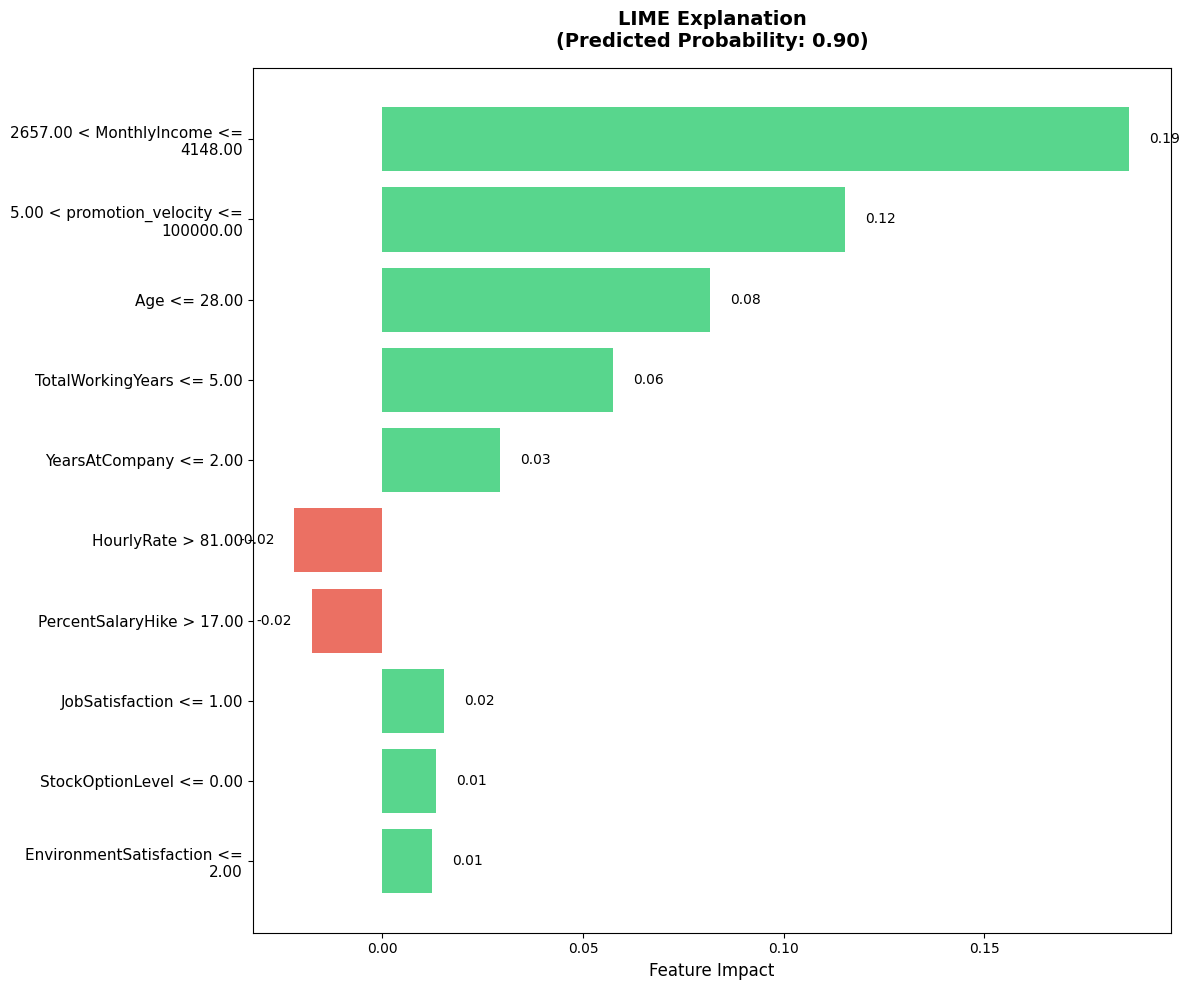

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap

values = [v for _, v in exp.as_list(label=1)]
features = [f for f, _ in exp.as_list(label=1)]
colors = ['#2ecc71' if v > 0 else '#e74c3c' for v in values]

wrapped_features = [textwrap.fill(f, width=30) for f in features]

fig, ax = plt.subplots(figsize=(12, 10))
y_pos = np.arange(len(wrapped_features))
bars = ax.barh(y_pos, values, color=colors, alpha=0.8)

ax.set_yticks(y_pos)
ax.set_yticklabels(wrapped_features, fontsize=11)
ax.invert_yaxis()
ax.set_xlabel('Feature Impact', fontsize=12)
ax.set_title(f'LIME Explanation\n(Predicted Probability: {pred_prob:.2f})', fontsize=14, weight='bold', pad=15)

for i, v in enumerate(values):
    ax.text(v + 0.005 if v > 0 else v - 0.005, i, f"{v:.2f}",
            va='center', ha='left' if v > 0 else 'right', fontsize=10)

plt.tight_layout()
plt.show()

This LIME plot explain why the model predicted a specific outcome with a hight probability (0.90) for this instance (specific employee). The strongest features that helped with that are monthly income being between 2657 and 4148, promotion velocity > 5 and being young (age < 28). In the other hands the features that slightly lowers the probability are HourlyRate (>81) and high PercecntSalaryHike (>17)

## SHAP Analysis

  0%|          | 0/100 [00:00<?, ?it/s]

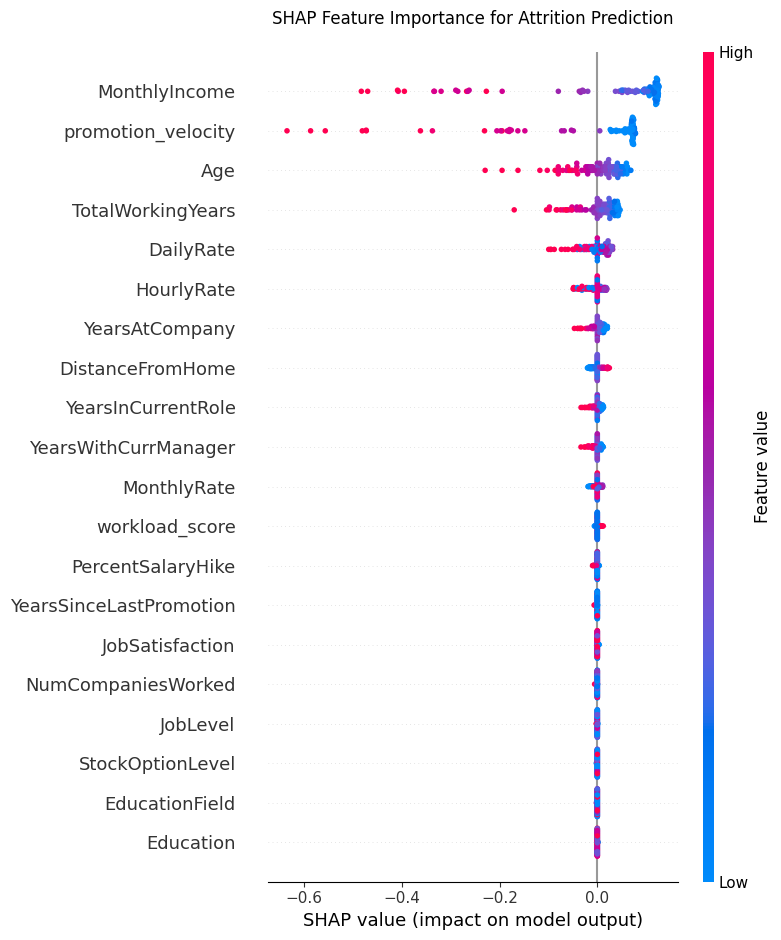

In [25]:
explainer = shap.KernelExplainer(pipeline.named_steps['classifier'].predict_proba, shap.sample(X_train, 100))
sample_size = min(100, len(X_test))
X_sample = X_test.iloc[:sample_size]

shap_values = explainer.shap_values(X_sample)

if len(np.array(shap_values).shape) == 3:
    shap_values_attrition = shap_values[:,:,1]
elif len(np.array(shap_values).shape) == 2:
    shap_values_attrition = shap_values

plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_attrition,
    X_sample,
    feature_names=X_train.columns.tolist(),
    plot_type="dot",
    show=False
)
plt.title("SHAP Feature Importance for Attrition Prediction", pad=20)
plt.tight_layout()
plt.show()

This Shape graph shows the most features that affects the target variable which is "Attrition". The top influencers are: Monthly Income, Promotion Velocity, and age. For example higher income and faster promotions reduces attrition, while younger age increases it. For the color interpretation, blue means higher risks while red means lower one, for example lower income (blue) rasises risks and high income (red) lowers it.

## Feature Importance (Model-Specific)

## Partial Dependence Plots

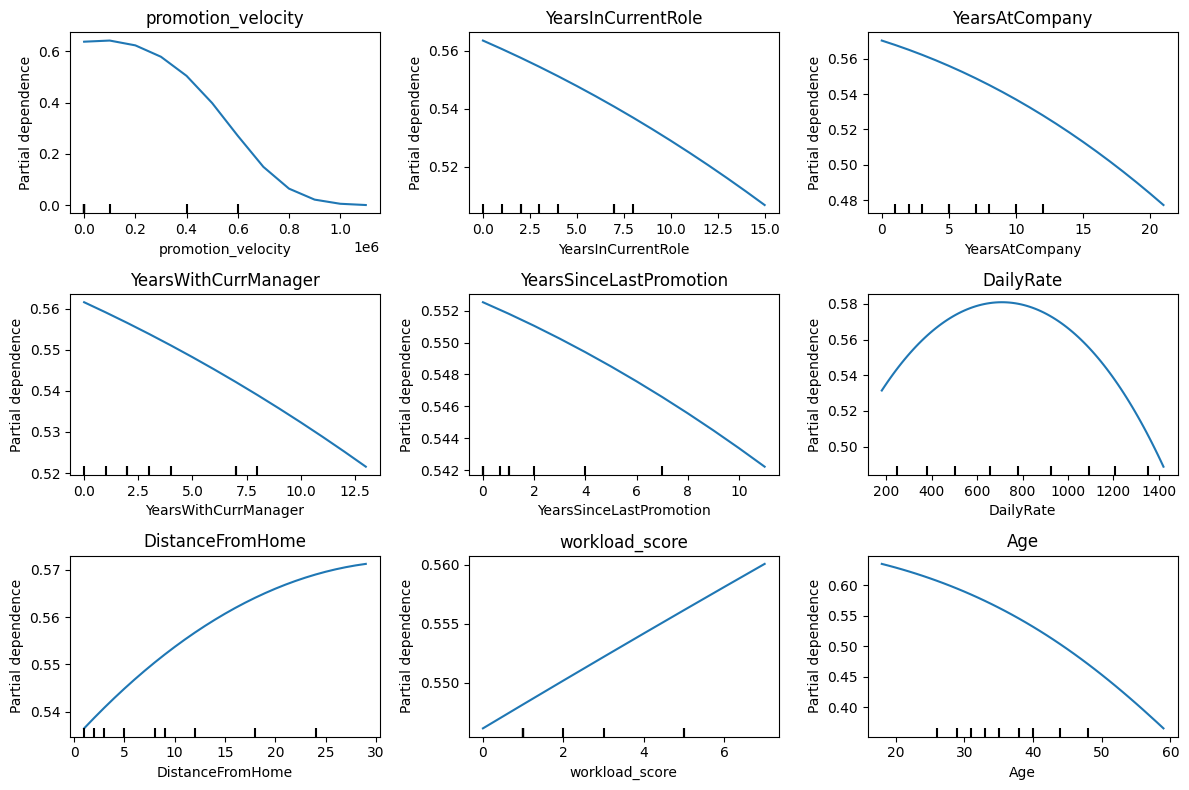

In [30]:
perm = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
top9 = X_train.columns[perm.importances_mean.argsort()][-9:][::-1]

fig, axes = plt.subplots(3, 3, figsize=(12, 8))
axes = axes.flatten()

for ax, feature in zip(axes, top9):
    PartialDependenceDisplay.from_estimator(pipeline, X_test, [feature], ax=ax)
    ax.set_title(feature)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

The PDP graph shows how different features influnces the target variable. The strongest insights comes from Age which shows a significant negative impact, dropping the target predection from 0.6 to 0.4. In the opposite direction DistanceFromHome increaess the target variable predection from 0.54 to 0.57, which suggest a positive effect with greater distance.

## Permutation Feature Importance

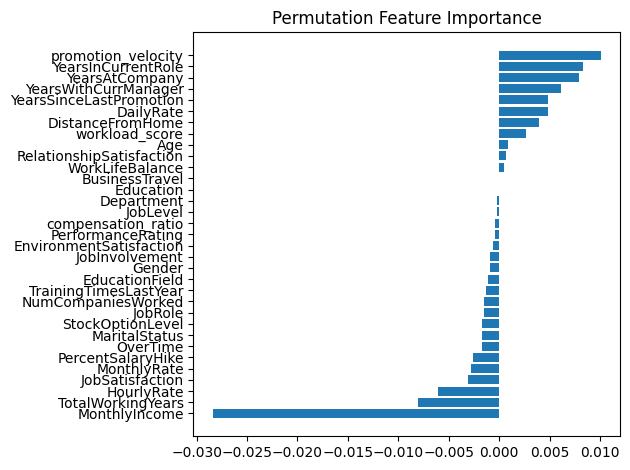

In [38]:
result = permutation_importance(
    pipeline.named_steps['classifier'],
    X_test[X_train.columns],
    y_test,
    n_repeats=10,
    random_state=42
)

sorted_idx = result.importances_mean.argsort()

plt.barh(X_train.columns[sorted_idx], result.importances_mean[sorted_idx])
plt.title("Permutation Feature Importance")
plt.tight_layout()

The PFI method tries to estimate how important a feature is for model results based on what happens to the model when we change the feature connected to the target variable. Features like promotion velocity and YearsInCurrentRole have the most impac, while features like MonthlyIncome have the least income. This might be irrelelvant but the low accuracy achevied by the NB model demonstrate that.

# **Save Results**

In [ ]:
# Code: Export model weights, metrics, and explanation artifacts